# Lab 6
## Author: Yakovlev Konstantin

### Description:
Visualize sampling from RMB for MNIST dataset (Gibbs sampling). Show how samples are changed for k iterations.


### Restricted Boltzmann Machine


Given binary bectors $\mathbf{v}, \mathbf{h}$ - visible and hidden units. Write down a joint energy function:

$$E(\mathbf{v}, \mathbf{h}) = -\mathbf{a}^\top\mathbf{v} - \mathbf{b}^\top\mathbf{h} -
\mathbf{v}^\top\mathbf{W}\mathbf{h}$$

Then joint likelihood takes the following form:

$$p(\mathbf{v}, \mathbf{h}) \propto \exp(-E(\mathbf{v}, \mathbf{h}))$$

Thus, we can easily get conditional probabilities:

$$p(\mathbf{h} = 1|\mathbf{v}) = \boldsymbol{\sigma}(\mathbf{b} + \mathbf{v}^\top\mathbf{W}),
\quad p(\mathbf{v} = 1|\mathbf{h}) = \boldsymbol{\sigma}(\mathbf{a} + \mathbf{W}\mathbf{h})$$


Using them and $\mathbf{x}_0$ from the dataset, we can sample from the model with Gibbs sampling.
Now get the gradients, using contrastive divergence:

$$\frac{\partial\log p(\mathbf{v})}{\partial\mathbf{W}} = \mathbb{E}_\text{data}\mathbf{v}\mathbf{h}^\top -
\mathbb{E}_\text{model}\mathbf{v}\mathbf{h}^\top$$

$$\frac{\partial\log p(\mathbf{v})}{\partial\mathbf{a}} = \mathbb{E}_\text{data}\mathbf{v} -
\mathbb{E}_\text{model}\mathbf{v}$$

$$\frac{\partial\log p(\mathbf{v})}{\partial\mathbf{b}} = \mathbb{E}_\text{data}\mathbf{h} -
\mathbb{E}_\text{model}\mathbf{h}$$

Now we can substitute the gradients to our favourite optimizer.


### Experimental setup

1. Binarized MNIST dataset. We sample pictures from bernoulli distribution
2. We visualize predicted probabilities, not binarized values
3. We used SGD with momentum for optimization


__Notes__

1. The code is based on [this implementation](https://github.com/bacnguyencong/rbm-pytorch). Note that there are some errors. In this lab everything is correct.


In [1]:
import jax.numpy as jnp
from jax import jit
from jax import random
from jax.nn import sigmoid

from dataclasses import dataclass
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
@dataclass
class Config:
    hidden_size: int = 128
    batch_size: int = 64
    num_epochs: int = 2
    
    k: int = 3  # Gibbs sampling steps
    sampling_steps: int = 5  # infernece Gibbs sampling steps
    learning_rate: float = 1e-3
    momentum: float = 0.9
    
config = Config()

In [3]:
class RBM():

    def __init__(self, num_visible, num_hidden, k, learning_rate=1e-3, momentum_coefficient=0.5,
                 weight_decay=1e-4):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        
        self.key = random.PRNGKey(0)
        x = random.normal(self.key, (10,))
        self.weights = random.normal(self.key, (num_visible, num_hidden)) * 0.1
        self.visible_bias = jnp.ones(num_visible) * 0.5
        self.hidden_bias = jnp.zeros(num_hidden)
        
        self.weights_momentum = jnp.zeros((num_visible, num_hidden))
        self.visible_bias_momentum = jnp.zeros(num_visible)
        self.hidden_bias_momentum = jnp.zeros(num_hidden)

    def sample_hidden(self, visible_probabilities):
        """Sample from p(h|v)"""
        hidden_activations = jnp.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = sigmoid(hidden_activations)
        
        self.key, subkey = random.split(self.key)
        hidden_bin = random.bernoulli(subkey, p=hidden_probabilities).astype(jnp.float32)
        return hidden_probabilities, hidden_bin

    def sample_visible(self, hidden_probabilities):
        """Sample from p(v|h)"""
        visible_activations = jnp.matmul(hidden_probabilities, self.weights.transpose()) + self.visible_bias
        visible_probabilities = sigmoid(visible_activations)
        
        self.key, subkey = random.split(self.key)
        vis_bin = random.bernoulli(subkey, p=visible_probabilities).astype(jnp.float32)
        return visible_probabilities, vis_bin

    def contrastive_divergence(self, input_data):
        """
            Get stochastic gradients and update all parameters using SGD with momentum
            and weight dacay
        """
        # Positive phase
        positive_hidden_probabilities, positive_hidden_activations = self.sample_hidden(input_data)
        positive_associations = jnp.matmul(input_data.transpose(), positive_hidden_activations)

        # Negative phase
        hidden_activations = positive_hidden_activations
        
        # Gibbs sampling
        for step in range(self.k):
            visible_probabilities, visible_activations = self.sample_visible(hidden_activations)
            
            hidden_probabilities, hidden_activations = self.sample_hidden(visible_activations)

        negative_visible_probabilities = visible_activations
        negative_hidden_probabilities = hidden_activations

        negative_associations = jnp.matmul(negative_visible_probabilities.transpose(),
                                           negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        self.visible_bias_momentum *= self.momentum_coefficient
        self.visible_bias_momentum += jnp.sum(input_data - negative_visible_probabilities, axis=0)

        self.hidden_bias_momentum *= self.momentum_coefficient
        self.hidden_bias_momentum += jnp.sum(positive_hidden_probabilities - negative_hidden_probabilities, axis=0)

        batch_size = input_data.shape[0]

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = jnp.mean((input_data - negative_visible_probabilities) ** 2)

        return error


## Dataset

In [4]:
class DatasetMNIST(Dataset):
    def __init__(self):
        super().__init__()
        dataset = torchvision.datasets.MNIST('data/', train=True, download=True)
        self._data = np.stack([np.asarray(x).reshape(-1) for x, y in tqdm(dataset)], axis=0)
        self._data_len = len(self._data)
        self.key = random.PRNGKey(0)

    def __getitem__(self, index):
        img = self._data[index]
        bin_img = (np.random.rand(*img.shape) <= img).astype(np.float32)
        return bin_img

    def __len__(self):
        return self._data_len
    

test_ds = torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
# prepare test 0-9 digits
test_digits = {}
for x, y in test_ds:
    if len(test_digits) == 10:
        break
    test_digits[y] = jnp.asarray(x)

In [5]:
dl = DataLoader(DatasetMNIST(), batch_size=config.batch_size,
                collate_fn=lambda l: jnp.stack(l, axis=0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:02<00:00, 26609.21it/s]


## Training loop

In [6]:
rbm = RBM(28 * 28, config.hidden_size, config.k, learning_rate=config.learning_rate,
         momentum_coefficient=config.momentum)

In [7]:
losses = []
for _ in range(config.num_epochs):
    for x in tqdm(dl):
        loss = rbm.contrastive_divergence(x)
        losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.22it/s]


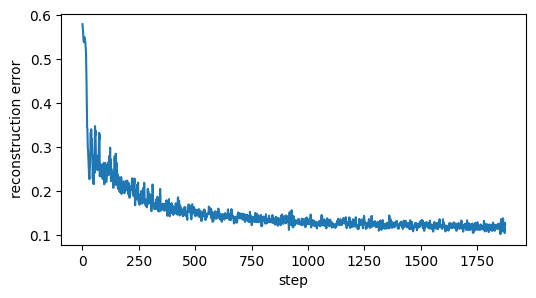

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('reconstruction error')
plt.show()

### Visualize Gibbs sampling

In [9]:
all_imgs = []
for j in range(10):
    x_probas = test_digits[j].reshape(-1)
    rbm.key, subkey = random.split(rbm.key)
    x_hat = (random.uniform(subkey, x_probas.shape) <= x_probas).astype(jnp.float32)

    imgs = [np.array(x_probas).reshape(28, 28)]
    
    # Gibbs sampling
    for _ in range(config.sampling_steps):
        h_probas, h_hat = rbm.sample_hidden(x_hat)
        x_probas, x_hat = rbm.sample_visible(h_hat)
        imgs.append(np.array(x_probas).reshape(28, 28))
        
    all_imgs.append(imgs)

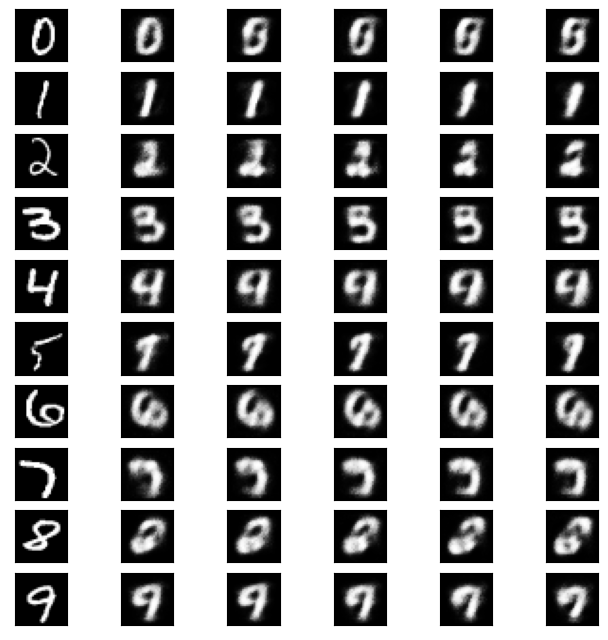

In [10]:
fig, axs = plt.subplots(10, config.sampling_steps + 1, figsize=(8, 8))
for i in range(config.sampling_steps + 1):
    for j in range(10):
        axs[j, i].imshow(all_imgs[j][i], cmap='gray')
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

### Results

We see that $p(\mathbf{v}|\mathbf{v}_0)$ is multimodal.

__Examples__

* $p(0|0) \approx p(5|0)$
* $p(3|3) \approx p(5|3)$
* $p(4|4) \approx p(9|4)$
* $p(5|5) \approx p(1|5)$
